# Refactorized TDD

In [1]:
import numpy as np
import time
import random
from qiskit import QuantumCircuit
import torch

import tdd
from tdd import CUDAcpl


# DEVICE : cuda



## Demonstrating TDD

Hellow world from tdd

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


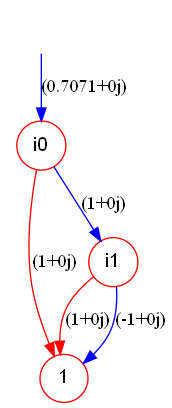

In [2]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tdd = tdd.as_tensor(U)

print(U_tdd.numpy())
U_tdd.show()

### TDD created with different index orders

#### 1. original order

[[[[ 0.5+0.j  0.5+0.j]
   [ 0.5+0.j  0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [ 0.5+0.j -0.5+0.j]]]


 [[[ 0.5+0.j  0.5+0.j]
   [-0.5+0.j -0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [-0.5+0.j  0.5+0.j]]]]


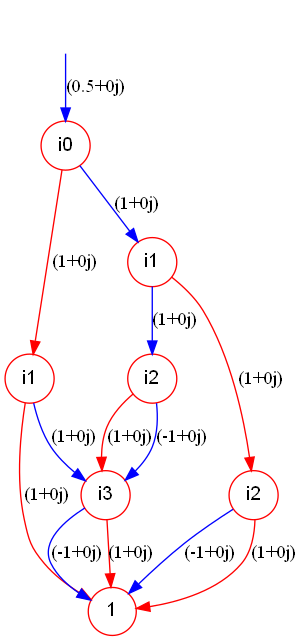

In [3]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd->acbd', U, U)
U_tdd = tdd.as_tensor((U_tensor,[],[0,1,2,3]))

print(U_tdd.numpy())
U_tdd.show()

#### 2. rearranged order

[[[[ 0.5+0.j  0.5+0.j]
   [ 0.5+0.j  0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [ 0.5+0.j -0.5+0.j]]]


 [[[ 0.5+0.j  0.5+0.j]
   [-0.5+0.j -0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [-0.5+0.j  0.5+0.j]]]]


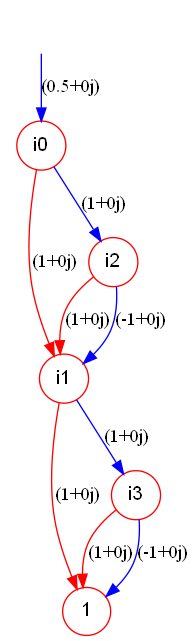

In [4]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd->acbd', U, U)
U_tdd = tdd.as_tensor((U_tensor,[],[0,2,1,3]))

print(U_tdd.numpy())
U_tdd.show()

### Parallel storage and calculation

#### storage without parallelization

[[[ 0.70710678+0.j  0.70710678+0.j]
  [ 0.70710678+0.j -0.70710678+0.j]]

 [[ 0.70710678+0.j  0.70710678+0.j]
  [-0.70710678+0.j  0.70710678+0.j]]]


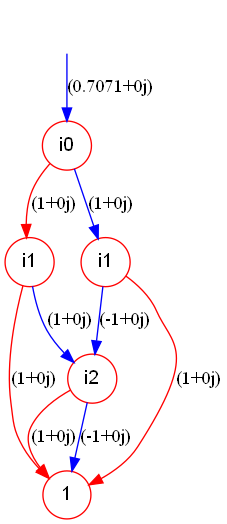

In [5]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[],[]))

print(U_tdd.numpy())
U_tdd.show()

#### storage with parallelization

[[[ 0.70710678+0.j  0.70710678+0.j]
  [ 0.70710678+0.j -0.70710678+0.j]]

 [[ 0.70710678+0.j  0.70710678+0.j]
  [-0.70710678+0.j  0.70710678+0.j]]]


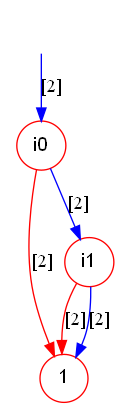

In [6]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2],[]))

print(U_tdd.numpy())
U_tdd.show()

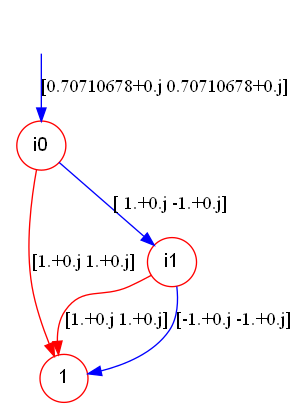

In [7]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2],[]))

U_tdd.show(full_output=True)

node weight demonstration

tensor([[[ 0.707106781186547,  0.000000000000000],
         [ 0.707106781186547,  0.000000000000000]],

        [[ 0.707106781186547,  0.000000000000000],
         [-0.707106781186547,  0.000000000000000]]], device='cuda:0',
       dtype=torch.float64)


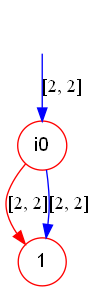

In [8]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2,2],[]))

print(U_tdd.weights)
U_tdd.show()

#### Demonstration of tdd's infimum type

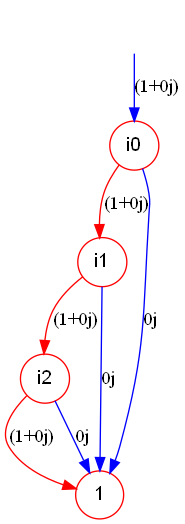

In [9]:
U = np.zeros((2,2,2))
U[0,0,0] = 1

U_tdd = tdd.as_tensor(U)
U_tdd.show()


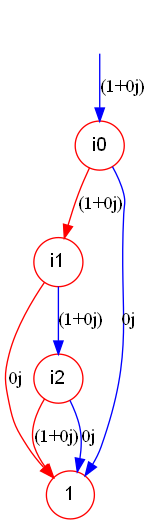

In [10]:
U = np.zeros((2,2,2))
U[0,1,0] = 1

U_tdd = tdd.as_tensor(U)
U_tdd.show()


the result of stack them together

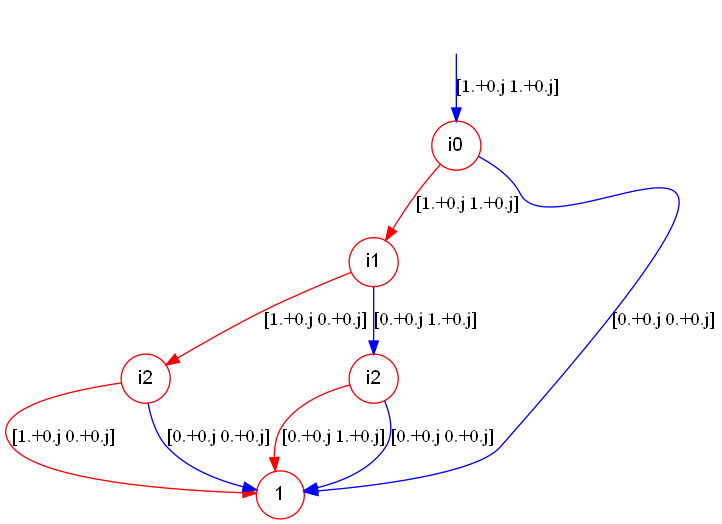

In [11]:
U1 = np.zeros((2,2,2))
U2 = np.zeros((2,2,2))
U1[0,0,0] = 1
U2[0,1,0] = 1

U_tdd = tdd.as_tensor((np.stack((U1,U2)),[2],[]))
U_tdd.show(full_output=True)

### indexing (slicing)

np result:
[[[[ 0.35355339  0.35355339]
   [ 0.35355339  0.35355339]]

  [[ 0.35355339 -0.35355339]
   [ 0.35355339 -0.35355339]]]


 [[[-0.35355339 -0.35355339]
   [-0.35355339 -0.35355339]]

  [[-0.35355339  0.35355339]
   [-0.35355339  0.35355339]]]]
tdd result:
[[[[ 0.35355339+0.j  0.35355339+0.j]
   [ 0.35355339+0.j  0.35355339+0.j]]

  [[ 0.35355339+0.j -0.35355339+0.j]
   [ 0.35355339+0.j -0.35355339+0.j]]]


 [[[-0.35355339+0.j -0.35355339+0.j]
   [-0.35355339+0.j -0.35355339+0.j]]

  [[-0.35355339+0.j  0.35355339+0.j]
   [-0.35355339+0.j  0.35355339+0.j]]]]


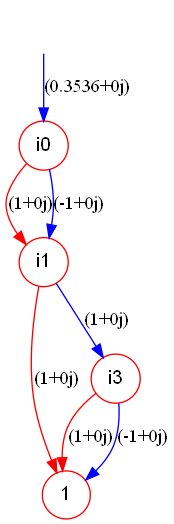

In [12]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd,ef->acebdf', U, U, U)

print('np result:')
print(U_tensor[:,0,:,1,...])

U_tdd = tdd.as_tensor((U_tensor,[],[0,3,1,4,2,5]))
U_tdd = U_tdd.index([(1,0),(3,1)])

print('tdd result:')
print(U_tdd.numpy())
U_tdd.show()

### tensordot

example1

np result:
[[1. 0.]
 [0. 1.]]
tdd result:
begin
contractions left:  1
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


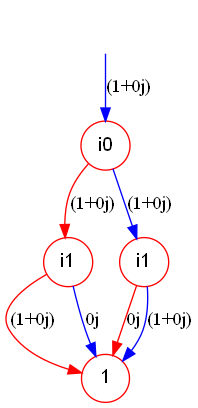

In [13]:
U=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

print('np result:')
print(np.tensordot(U, U, 1))

print('tdd result:')
U_tdd=tdd.as_tensor((U,[],[1,0]))
tdd_dot = tdd.tensordot(U_tdd,U_tdd,1)

print(tdd_dot.numpy())
tdd_dot.show()

example2

np result:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
tdd result:
begin
contractions left:  2
contractions left:  1
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


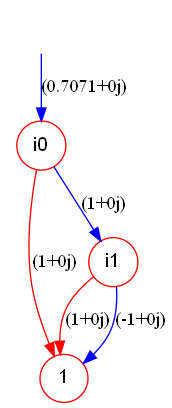

In [14]:
U=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

print('np result:')
print(U @ U @ U)

print('tdd result:')
U_prod = np.einsum('ab,cd,ef->acebdf',U,U,U)
U_tdd=tdd.as_tensor((U_prod,[],[0,1,3,4,2,5]))
tdd_dot = U_tdd.contract([[1,3],[2,4]])

print(tdd_dot.numpy())
tdd_dot.show()

## Comparing Performance

timing function

In [15]:
def timing(method, count=1):
    t1 = time.process_time()
    for i in range(count):
        method()
    t2 = time.process_time()
    print('total time: {}s, average time: {}s'.format(t2-t1, (t2-t1)/count))

def test_method():
    a = np.random.random((100,100))
timing(test_method,100000)

total time: 7.5625s, average time: 7.5625e-05s


In [16]:
import tdd_origin
from tdd import CUDAcpl
from tdd_origin import TDD, TN

### 1. 100 shot single-qubit gate multiplication

produce the same gates

In [58]:
count = 1
width = 4

rand_para_1 = torch.tensor(np.random.random((count, width)), device = 'cuda')
rand_para_2 = torch.tensor(np.random.random((count, width)), device = 'cuda')

gates_1 = CUDAcpl.ones(shape=(count,1,1))
gates_2 = CUDAcpl.ones(shape=(count,1,1))
for i in range(width):
    gates_1 = CUDAcpl.einsum('kab,kcd->kacbd', gates_1,
         CUDAcpl.quantum_basic.Rx(rand_para_1[:,i])).reshape((count,2**(i+1), 2**(i+1),2))
    gates_2 = CUDAcpl.einsum('kab,kcd->kacbd', gates_2,
         CUDAcpl.quantum_basic.Rx(rand_para_2[:,i])).reshape((count,2**(i+1), 2**(i+1),2))
gates_1 = gates_1.reshape((count,)+(2,)*width*2+(2,))
gates_2 = gates_2.reshape((count,)+(2,)*width*2+(2,))

gates_1_np = CUDAcpl.CUDAcpl2np(gates_1)
gates_2_np = CUDAcpl.CUDAcpl2np(gates_2)

print(gates_1.shape)
print(gates_1_np.shape)

torch.Size([1, 2, 2, 2, 2, 2, 2, 2, 2, 2])
(1, 2, 2, 2, 2, 2, 2, 2, 2)


PyTorch

In [49]:
indices1 =[]
indices2 =[]
for i in range(width):
    indices1.append(1+i*2+1)
    indices2.append(1+i*2)

result = CUDAcpl.tensordot(gates_1, gates_2, [indices1, indices2])
print(result[0])

tensor([[[[[[[[[[[[[[ 4.002970527196423e+00,  0.000000000000000e+00],
                    [ 0.000000000000000e+00, -7.256333870863514e-01]],

                   [[ 0.000000000000000e+00, -2.305876962627773e-01],
                    [-4.179949113359720e-02,  0.000000000000000e+00]]],


                  [[[ 0.000000000000000e+00, -1.866175084389456e+00],
                    [-3.382885130383648e-01,  0.000000000000000e+00]],

                   [[-1.074994208947477e-01,  0.000000000000000e+00],
                    [ 0.000000000000000e+00,  1.948682069071086e-02]]]],



                 [[[[ 0.000000000000000e+00, -7.256333870863514e-01],
                    [ 4.002970527196423e+00,  0.000000000000000e+00]],

                   [[-4.179949113359720e-02,  0.000000000000000e+00],
                    [ 0.000000000000000e+00, -2.305876962627773e-01]]],


                  [[[-3.382885130383648e-01,  0.000000000000000e+00],
                    [ 0.000000000000000e+00, -1.866175084389456e+00]],

TDD (original)

In [59]:
TDD.Ini_TDD([str(i)+'0' for i in range(width)]+[str(i)+'1' for i in range(width)]+[str(i)+'2' for i in range(width)])
var1 = []
var2 = []
for i in range(width):
    var1.append(TN.Index(str(i)+'0'))
    var1.append(TN.Index(str(i)+'1'))
    var2.append(TN.Index(str(i)+'1'))
    var2.append(TN.Index(str(i)+'2'))
ts1 = TN.Tensor(gates_1_np[0], var1)
ts2 = TN.Tensor(gates_2_np[0], var2)

tdd1 = ts1.tdd()
tdd2 = ts2.tdd()
print(tdd2.to_array())
'''
tn = TN.TensorNetwork([ts1,ts2])
result = tn.cont()
#print(result.to_array())
#result.show()
'''

[[[[[[[[ 8.16729180e-01+0.00000000e+00j
         0.00000000e+00-3.34569946e-01j]
       [ 0.00000000e+00-4.07770021e-01j
        -1.67041410e-01-0.00000000e+00j]]

      [[ 0.00000000e+00-3.34569946e-01j
         8.16729180e-01+0.00000000e+00j]
       [-1.67041410e-01-0.00000000e+00j
         0.00000000e+00-4.07770021e-01j]]]


     [[[ 0.00000000e+00-4.07770021e-01j
        -1.67041410e-01-0.00000000e+00j]
       [ 8.16729180e-01+0.00000000e+00j
         0.00000000e+00-3.34569946e-01j]]

      [[-1.67041410e-01-0.00000000e+00j
         0.00000000e+00-4.07770021e-01j]
       [ 0.00000000e+00-3.34569946e-01j
         8.16729180e-01+0.00000000e+00j]]]]



    [[[[ 0.00000000e+00-1.35627628e-01j
        -5.55593327e-02-0.00000000e+00j]
       [-6.77150787e-02-0.00000000e+00j
        -0.00000000e+00+2.77392198e-02j]]

      [[-5.55593327e-02-0.00000000e+00j
         0.00000000e+00-1.35627628e-01j]
       [-0.00000000e+00+2.77392198e-02j
        -6.77150787e-02-0.00000000e+00j]]]


     [[[

'\ntn = TN.TensorNetwork([ts1,ts2])\nresult = tn.cont()\n#print(result.to_array())\n#result.show()\n'

TDD (refactorized)

In [60]:
indices1 =[]
indices2 =[]
for i in range(width):
    indices1.append(i*2+1)
    indices2.append(i*2)
tdd1 = tdd.as_tensor((gates_1,[count],[]))
tdd2 = tdd.as_tensor((gates_2,[count],[]))
print(tdd2)
'''
result = tdd.tensordot(tdd1, tdd2, [indices1, indices2])
print(result)
result.show(full_output=True)
'''

[[[[[[[[[ 8.16729180e-01+0.00000000e+00j
          0.00000000e+00-6.76943068e-04j]
        [ 0.00000000e+00-4.07770021e-01j
         -3.37978727e-04+0.00000000e+00j]]

       [[ 0.00000000e+00-1.35627628e-01j
         -1.12414476e-04+0.00000000e+00j]
        [-6.77150787e-02+0.00000000e+00j
          0.00000000e+00+5.61254015e-05j]]]


      [[[ 0.00000000e+00-3.34569946e-01j
         -2.77307107e-04+0.00000000e+00j]
        [-1.67041410e-01+0.00000000e+00j
          0.00000000e+00+1.38451677e-04j]]

       [[-5.55593327e-02+0.00000000e+00j
          0.00000000e+00+4.60501547e-05j]
        [ 0.00000000e+00+2.77392198e-02j
          2.29915534e-05+0.00000000e+00j]]]]



     [[[[ 0.00000000e+00-6.76943068e-04j
          8.16729180e-01+0.00000000e+00j]
        [-3.37978727e-04+0.00000000e+00j
          0.00000000e+00-4.07770021e-01j]]

       [[-1.12414476e-04+0.00000000e+00j
          0.00000000e+00-1.35627628e-01j]
        [ 0.00000000e+00+5.61254015e-05j
         -6.77150787e-02+0.000

'\nresult = tdd.tensordot(tdd1, tdd2, [indices1, indices2])\nprint(result)\nresult.show(full_output=True)\n'